![](images/logoai.png)
![](images/globaai.jpg)

### The Origin of MNIST Handwritten Digit Dataset
The MNIST Handwritten Digit Dataset is contributed by Yann LeCun, Corinna Cortes and Christopher Burges to train a machine learning model to solve the issue of handwritten digit classification. Each image is a 28 by 28 pixel square (784 pixels total). This dataset contains 60,000 training images and 10,000 testing images in total for 10 different digits (0 to 10).

### What is Pytorch?
PyTorch is an open-source deep learning library for Python, based on Torch, used for applications such as natural language processing, image recognition, image classification, text processing, etc. It is primarily developed by Facebook’s artificial-intelligence research group. PyTorch provides two high-level features:
- Tensor computation (like NumPy) with strong GPU acceleration
- Deep neural networks built on a tape-based autodiff system

### What is Azure Notebook?
Azure Notebooks is a free service for anyone to develop and run code in their browser using Jupyter. Jupyter is an open source project that enables combing markdown prose, executable code, and graphics onto a single canvas. Azure Notebooks currently supports Python 2, Python 3, R, F# and their popular packages. All the developed code and used data will be stored on the cloud.

#### Step 1: Log in to Microsoft Azure Notebook:
Go to https://notebooks.azure.com/, login with your credential. After you successfully login, the screen will be automatically jumped to the figure as shown below.
![](images/aznotebooks1.png)

Click on “My Projects” on the task-bar. Then, create a new project by pressing the button “New Project”.
Fill in the project name. After that, click the button “Create”.
A new folder for this project is created.
![](images/aznotebooks2.png)

![](images/aznotebooks3.png)

#### Step 2: Create new notebook named “demo”
Click on the button “+”, choose “Notebook”.
Fill in the Notebook Name as “Demo”. Choose “Python 3.6” and click button “New”.
A new notebook is created now for this project.
![](images/aznotebooks4.png)

# Digit Recognition Task
If this is your first time running a notebook - welcome!! Notebooks are awesome because they let us play around and experiment
with code with near-instant feedback. Some pointers:
1. To execute a cell, click on it and hit SHIFT-Enter
2. Once something is executed, the variables are in memory - inspect them!

## Getting Started
This first cell imports the necessary libraries so we can get started:
1. Numpy — A fundamental package for scientific computing with Python. It contains a powerful N-dimensional array object, sophisticated (broadcasting) functions, tools for integrating C/C++ and Fortran code and useful linear algebra, Fourier transform, and random number capabilities.
2. Matplotlib — A Python 2D plotting library which produces publication quality figures in a variety of hard copy formats and interactive environments across platforms.
3. Torch — An open-source machine learning library, a scientific computing framework, and a script language based on the Lua programming language.
4. Torchvision — A package consists of popular datasets, model architectures, and common image transformations for computer vision.
5. Time — A module provides various time-related functions.

In [24]:
import numpy as np
import torch
import torchvision
import torch.onnx as onnx
import torch.nn.functional as F
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from collections import defaultdict
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Let's also check to make sure torch thinks we can use the GPU.

In [25]:
torch.cuda.is_available()

True

In [70]:
no_cuda=True
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using {} device'.format(device))

Using cpu device


This should be True. If you see False here, something is wrong and torch isn't going to be able to run on the GPU.

Possible causes to seeing False at this point:

You don't have a GPU (see above with regards to the nvidia-smi check)
You have a CPU-only version of pytorch installed, in which case you need to install the gpu enabled version
You don't have the CUDA library
You don't have the CUDA library path included on either the PATH or LD_LIBRARY_PATH variables
You have the wrong version of CUDA for the version of pytorch
Probably other possiblities

 ## Data!
 Without data we really can't do anything with machine learning. At this point we have our sharp question **can we predict a digit given a 28x28 vector of numbers?**
 
 Once that is all squared away we need to take a look at our data. The next cell is a helper function that visualizes the the digits (a sanity check).


### Define the pre-processing methods

Image transformations are applied onto the images so they can be fed into the model later for training or testing and improve the model accuracy.

- transforms.RandomRotation(10) — Rotate the image in the range of [-10, 10] degrees randomly.
- transforms.ToTensor() — Convert theimage to tensor.
- transforms.Normalize((0.5,), (0.5,)) — Normalize the tensor image with mean and standard deviation. In this case, mean=0.5 and std=0.5.

In [27]:
transform = transforms.Compose([transforms.RandomRotation(10), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                              ])

### Preparation of training and testing dataset and dataloader

The operations of these codes are:
Download the MNIST handwritten digit recognition dataset into the “train” and “test” folders.
Generate the train and test datasets by inputting the downloaded images and transforming them based on defined pre-processing methods in the previous step.
Define the train and test loaders by setting 64 images will be fed into the model in each epoch randomly for training and non-randomly for testing.

The next cell downloads the standard digit dataset (called MNIST). The `transform` and `target_transform` parts of this call add some conversion steps to make the data more suitable for the models we will try.

In [28]:
trainset = datasets.MNIST('train', download=True, train=True, transform=transform)
testset = datasets.MNIST('test', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Here is our sanity check!

In [29]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: train
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

### Data Visualization

The images can be reconstructed and plotted by loading one batch of images.

In [30]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


As you can see, the shape of the image is (64, 1, 28, 28). For each batch except the last batch, there are 64 grey-scale images. Each image contains 1 channel (grey-scale), 28 pixels of width and 28 pixels of height.

Print the unique elements of our dataset:

In [31]:
y_unq = np.unique(labels)
print(np.unique(labels))

[0 1 2 3 4 5 6 7 8 9]


In [32]:
labellist=[]
for images, labels in trainloader:
    labellist.append(labels[0].item())

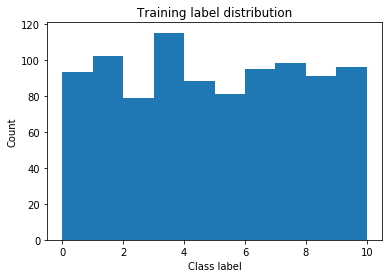

In [33]:
bin_edges = np.concatenate([y_unq, y_unq[[-1]] + 1])
plt.hist(labellist, bins=bin_edges)
plt.xlabel('Class label')
plt.ylabel('Count')
plt.title('Training label distribution')
plt.show()

Feel free to take a look at the data by printing out `x` and/or `y`. They really are just numbers! A couple of things that might seem strange when you print them out:
1. "I thought you said the images were 784 sized vectors of 0-255???" - They were! We just normalized the vectors by dividing by 255 so the new range is 0-1 (it makes the numbers more tidy)
2. "I thought the `y` was a numerical answer?? Instead it's a 10 sized vector!" - Yes - this is called a one-hot encoding of the answer. Now there's a `1` in the index of the right answer. Again, this makes the math work a lot better for the models we will be creating.

In [34]:
x, y = trainset[0]
print(x)
print(y)

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

### Plot the images with Matplotlib library.

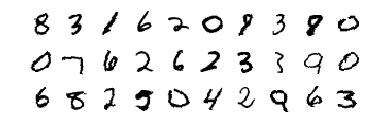

In [37]:
figure = plt.figure()
num_of_images = 30
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Choosing Models and define the network architecture
![](images/network.png)
Now that we have some data it's time to start picking models we think might work. This is where the science part of data-science comes in: we guess and then check if our assumptions were right. Imagine models like water pipes that have to distribute water to 10 different hoses depending on 784 knobs. These 784 knobs represent the individual pixels in the digit and the 10 hoses at the end represent the actual number (or at least the index of the one with the most water coming out of it). Our job now is to pick the plumbing in between.

The next three cells represent three different constructions in an increasingly more complex order:

1. The first is a simple linear model,
2. The second is a 3 layer Neural Network,
3. and the last is a full convolutional neural network

While it is out of the scope of this tutorial to fully explain how they work, just imagine they are basically plumbing with internal knobs that have to be tuned to produce the right water pressure at the end to push the most water out of the right
index. As you go down each cell the plumbing and corresponding internal knobs just get more complicated.

In [38]:
class SimpleLinear(nn.Module):
    def __init__(self):
        super(SimpleLinear, self).__init__()
        self.layer1 = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.layer1(x)
        return F.softmax(x, dim=1)

In [39]:
class NeuralNework(nn.Module):
    def __init__(self):
        super(NeuralNework, self).__init__()
        self.layer1 = nn.Linear(28*28, 512)
        self.layer2 = nn.Linear(512, 512)
        self.output = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output(x)
        return F.softmax(x, dim=1)

In [40]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [41]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


# Optimizing Model Parameters. 
## Define the criterion or loss function and optimizer
Now that we have some models it's time to optimize the internal parameters to see if it can do a good job at recognizing digits! It turns out there are some parameters that we can give the optimization algorithm to tune how it trains - these are called hyper-parameters. That's what the two variables represent below:

In [42]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

The `learning_rate` basically specifies how fast the algorithm will learn the model parameters. Right now you're probably thinking "let's set it to fifty million #amirite?" The best analogy for why this is a bad idea is golf. I'm a terrible golfist (is that right?) so I don't really know anything - but pretend you are trying to sink a shot (again sorry) but can only hit the ball the same distance every time. Easy right? Hit it the exact length from where you are to the hole! Done! Now pretend you don't know where the hole is but just know the general direction. Now the distance you choose actually matters. If it is too long a distance you'll miss the hole, and then when you hit it back you'll overshoot again. If the distance is too small then it will take forever to get there but for sure you'll eventually get it in. Basically you have to guess what the right distance per shot should be and then try it out. That is basically what the learning rate does for finding the "hole in one" for the right parameters (ok, I'm done with the golf stuff).

Below there are three things that make this all work:
1. **The Model** - this is the function we're making that takes in the digit vector and should return the right number
2. **The Cost Function** (sometimes called the loss function). I know I promised I was done with golf but I lied. Remember how I said in our screwy golf game you knew the general direction of the hole? The cost function tells us the distance to the hole - when it's zero we're there! In actual scientific terms, the cost function tells us how bad the model is at getting the right answer. As we take shots you should see the cost function decreasing. If this does not happen then something is wrong. At this point I would change the shot distance (or `learning_rate`) to something smaller and try again. If that doesn't work maybe change the model!
3. **The Optimizer** - this part is the bit that actually changes the model parameters. It has a sense for the direction we should be shooting and updates all of the internal numbers inside the model to find the best internal knobs to predict the right digits. In this case I am using the Binary Cross Entropy cost function because, well, I know it works. There are a ton of different cost functions you can choose from that fit a variety of different scenarios.

In [43]:
# criterion = nn.NLLLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

I forgot to mention the whole `cuda` thing. GPUs speed this whole process up because this is basically all a big Matrix multiplcation problem in a `for` loop. PyTorch is great because you basically need to tell the model where to run (either on the CPU or using CUDA - which is a platform for moving computations to the GPU).

Now for the learning part! The `dataloader`'s job is to iterate through the entire dataset (in this case 60,000 examples of digits and their corresponding label) but to take chunks of size `batch_size` of the data to process. This is another hyperparameter that needs to be chosen. `epochs` is the number of times we want to loop through the dataset in its entirety (again something we choose based upon how our experiment goes).

A word on how long this takes - it takes a while.

# Train the model

We'll:
1. Record the start time of the training.
2. Set the training epoch to 20.
3. For each epoch, reset the running loss to 0, train the model then print the running loss after each epoch.
4. Record the end time of the training. Display the duration by using the end training time minus start training time.

In [44]:
log_interval=10
train_log = defaultdict(list)
val_log = defaultdict(list)

In [45]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    train_log = defaultdict(list)
    t_log = time()
    n_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        t0 = time()
        data, target = data.to(device), target.to(device).long()
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        t1 = time()
        loss.backward()
        t2 = time()
        optimizer.step()
        t3 = time()
        n_samples += data.shape[0]
        if batch_idx % log_interval == 0:
            pred = output.max(1, keepdim=True)[1]
            correct = pred.eq(target.view_as(pred)).sum().item()

            train_log['n_iter'].append(epoch * len(train_loader) + batch_idx + 1)
            train_log['n_samples'].append(n_samples + (epoch - 1) * len(train_loader.dataset))
            train_log['loss'].append(loss.detach())
            train_log['accuracy'].append(100. * correct / data.shape[0])
            train_log['time_batch'].append(t3 - t0)
            train_log['time_batch_forward'].append(t1 - t0)
            train_log['time_batch_backward'].append(t2 - t1)
            train_log['time_batch_update'].append(t3 - t2)
            t4 = time()
            train_log['time_batch_avg'].append((t4 - t_log) / log_interval)
            print(
                'Train Epochs: {} [{:5d}/{:5d} ({:3.0f}%)]'
                '\tLoss: {:.6f}'
                '\tTime: {:.4f}ms/batch'.format(
                    epoch, n_samples, len(train_loader.dataset),
                    100. * (batch_idx + 1) / len(train_loader), loss.item(),
                    1000 * (t4 - t_log) / log_interval,
                )
            )
            t_log = time()
    return train_log

# Test the model
The operations of these codes are:
1. Initialize the variables “correct_count” and “all_count” for accuracy calculation.
2. Load the test images, feed the images into the well-trained model and get the outputs.
3. Compare the outputs’ label with the original label. It will be counted as a correct prediction if output label is same with original label for each test image.
4. Display the accuracy score of the model. The accuracy of this model is 95%.

In [46]:
def test(model, device, test_loader, log_interval):
    model.eval()
    test_loss = 0
    correct = 0
    preds = []
    targets = []
    num_batches = 0
    with torch.no_grad():
        for data, target in test_loader:
            num_batches += 1
            data, target = data.to(device), target.to(device).long()
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            preds.append(pred.cpu().numpy())
            targets.append(target.cpu().numpy())
    
    # Remove list nesting
    preds = np.concatenate(preds).squeeze()
    targets = np.concatenate(targets).squeeze()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'
        ''.format(
            test_loss,
            correct, len(test_loader.dataset), accuracy,
            )
        )
    return test_loss, accuracy

In [47]:
epoch_log = train(model, device, trainloader, optimizer, epochs, log_interval)
for key, value in epoch_log.items():
    train_log[key] += value
val_loss, val_accuracy = test(model, device, testloader, log_interval)
val_log['loss'].append(val_loss)
val_log['accuracy'].append(val_accuracy)

Train Epochs: 5 [   64/60000 (  0%)]	Loss: 2.302243	Time: 533.8186ms/batch
Train Epochs: 5 [  704/60000 (  1%)]	Loss: 2.296829	Time: 37.0691ms/batch
Train Epochs: 5 [ 1344/60000 (  2%)]	Loss: 2.279196	Time: 42.0676ms/batch
Train Epochs: 5 [ 1984/60000 (  3%)]	Loss: 2.283670	Time: 37.4693ms/batch
Train Epochs: 5 [ 2624/60000 (  4%)]	Loss: 2.230797	Time: 41.1269ms/batch
Train Epochs: 5 [ 3264/60000 (  5%)]	Loss: 2.136690	Time: 42.7024ms/batch
Train Epochs: 5 [ 3904/60000 (  7%)]	Loss: 2.097810	Time: 38.4046ms/batch
Train Epochs: 5 [ 4544/60000 (  8%)]	Loss: 2.097883	Time: 39.1937ms/batch
Train Epochs: 5 [ 5184/60000 (  9%)]	Loss: 1.968742	Time: 40.1964ms/batch
Train Epochs: 5 [ 5824/60000 ( 10%)]	Loss: 2.069069	Time: 41.2916ms/batch
Train Epochs: 5 [ 6464/60000 ( 11%)]	Loss: 1.950749	Time: 43.6210ms/batch
Train Epochs: 5 [ 7104/60000 ( 12%)]	Loss: 1.966760	Time: 40.3002ms/batch
Train Epochs: 5 [ 7744/60000 ( 13%)]	Loss: 1.879812	Time: 42.1135ms/batch
Train Epochs: 5 [ 8384/60000 ( 14%)]	

In [48]:
for p in model.parameters():
    print(p.shape)
    print(p)

torch.Size([10, 1, 5, 5])
Parameter containing:
tensor([[[[-0.1675, -0.1532, -0.1937, -0.1861,  0.3139],
          [-0.2418, -0.3484, -0.0777, -0.2709,  0.2543],
          [-0.2459, -0.3500, -0.1760,  0.0058,  0.3174],
          [-0.3161, -0.2588, -0.3048, -0.0443,  0.3666],
          [-0.0112, -0.1303, -0.1174,  0.2805,  0.2943]]],


        [[[-0.2719, -0.3036, -0.2858, -0.2445, -0.1457],
          [-0.1430, -0.4312, -0.1720,  0.0023, -0.0512],
          [-0.1889, -0.3040,  0.1154, -0.0220,  0.1630],
          [ 0.2401,  0.3352,  0.4510,  0.4505,  0.0639],
          [ 0.4333,  0.3742,  0.2878,  0.0887, -0.0723]]],


        [[[-0.2660, -0.0574,  0.2728,  0.2032,  0.0459],
          [ 0.0325,  0.1052,  0.2080,  0.1229, -0.1684],
          [-0.0296,  0.1514,  0.4553, -0.2854, -0.1909],
          [ 0.3056,  0.3787,  0.2986, -0.1607, -0.3527],
          [ 0.2024,  0.4012, -0.0066, -0.2870, -0.2043]]],


        [[[-0.3250, -0.0986,  0.2882,  0.2927,  0.2040],
          [-0.2597,  0.0856,

       device='cuda:0', requires_grad=True)
torch.Size([20])
Parameter containing:
tensor([-0.0355, -0.0663, -0.0070,  0.0555,  0.0004,  0.0543, -0.0153, -0.0219,
        -0.0088,  0.0536,  0.0360,  0.0346, -0.0018,  0.0554,  0.0305, -0.0523,
         0.0389,  0.0413, -0.0291, -0.0500], device='cuda:0',
       requires_grad=True)
torch.Size([50, 320])
Parameter containing:
tensor([[-0.0326, -0.0529, -0.0413,  ...,  0.0013,  0.0159, -0.0574],
        [ 0.0610, -0.0703, -0.1132,  ...,  0.0300,  0.0688,  0.0229],
        [ 0.0905,  0.0156,  0.0179,  ...,  0.0186, -0.0796, -0.0741],
        ...,
        [ 0.0267,  0.0056, -0.0368,  ..., -0.0086,  0.0100,  0.0502],
        [-0.1533, -0.0697, -0.0346,  ...,  0.0567,  0.0662, -0.0328],
        [ 0.0157, -0.0596, -0.0044,  ..., -0.0053, -0.1314,  0.0242]],
       device='cuda:0', requires_grad=True)
torch.Size([50])
Parameter containing:
tensor([-0.0183,  0.0050,  0.0270,  0.0550,  0.0173,  0.0141, -0.0555,  0.0177,
         0.0384,  0.0208, -

       device='cuda:0', requires_grad=True)
torch.Size([10])
Parameter containing:
tensor([ 0.0257,  0.2220, -0.1858, -0.0058,  0.0298,  0.1546, -0.1204,  0.0471,
        -0.1822,  0.0105], device='cuda:0', requires_grad=True)


# Is it working???
The best way to figure out if it is working is to test the model on data the learning process hasn't used. Luckily we have such a dataset (it is basically a held out section of the data we already have used). I'm loading it all up the same way as before and printing them out to show you that they're different.

In [68]:
def collapse_nested_list(l):
    return [a for b in l for a in b]

def plot_training_log(train_log, val_log):
    xx_train = np.array(train_log['n_samples']) / 1000
    n_epoch = len(val_log['loss'])
    xx_val = np.arange(1, n_epoch + 1) * xx_train[-1] / n_epoch
    
    plt.plot(xx_train, train_log['loss'], 'b')
    # We prepend the first train loss score so there are enough datapoints to plot
    # a line, even with a single epoch.
    plt.plot(np.concatenate([[0], xx_val]), [train_log['loss'][0]] + val_log['loss'], 'ro-')
    plt.title('Loss (lower is better)')
    plt.xlabel('Number of samples presented (1000s)')
    plt.ylabel('Cross-Entropy Loss')
    plt.show()
    
    plt.plot(xx_train, train_log['accuracy'], 'b')
    plt.plot(np.concatenate([[0], xx_val]), [train_log['accuracy'][0]] + val_log['accuracy'], 'ro-')
    plt.title('Accuracy (higher is better)')
    plt.xlabel('Number of samples presented (1000s)')
    plt.ylabel('Accuracy (%)')
    plt.show()
    
    if n_epoch > 1:
        plt.plot(xx_train, train_log['accuracy'], 'b')
        plt.plot(np.concatenate([[0], xx_val]), [10] + val_log['accuracy'], 'ro-')
        plt.ylim([90, 100])
        plt.title('Accuracy, zoomed in')
        plt.xlabel('Number of samples presented (1000s)')
        plt.ylabel('Accuracy (%)')
        plt.show()
    
    plt.plot(xx_train, 1000 * np.array(train_log['time_batch_avg']), 'b')
    plt.title('Training speed (lower is better)')
    plt.xlabel('Number of samples presented (1000s)')
    plt.ylabel('Duration per batch (ms)')
    plt.show()

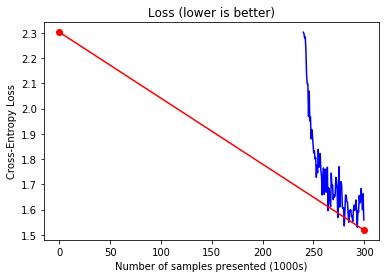

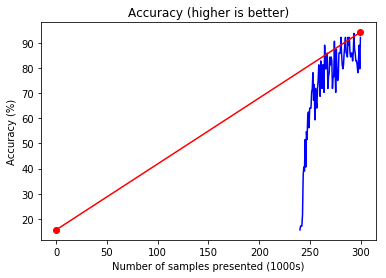

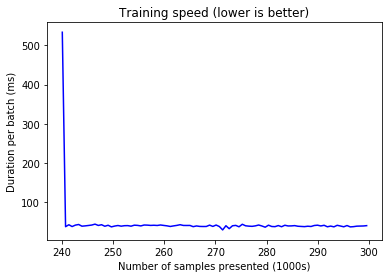

In [69]:
plot_training_log(train_log, val_log)

# Output Visualization

Let's see how well we do over *all* of the test data!

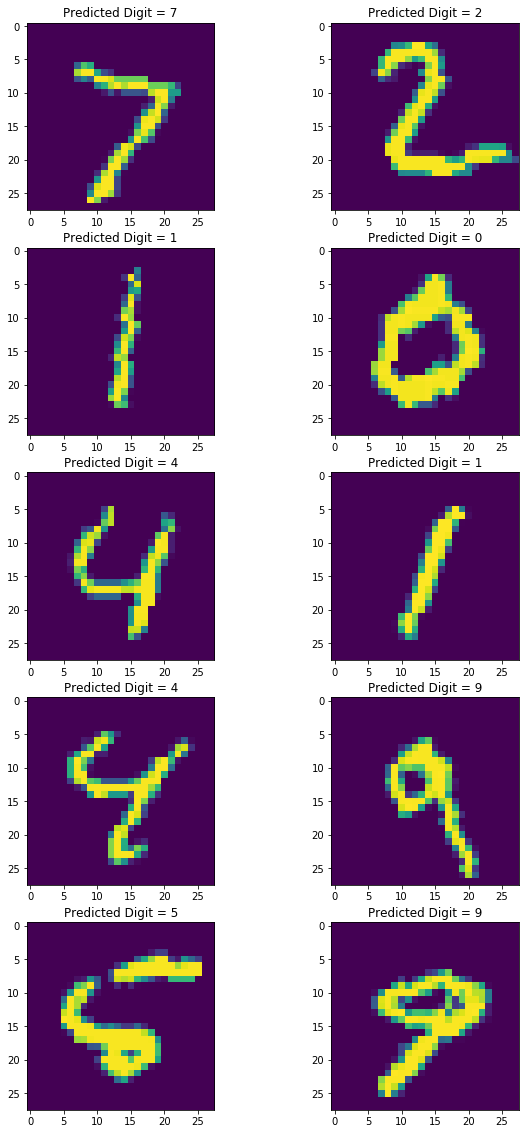

In [52]:
images, labels = next(iter(testloader))
if not no_cuda:
    images = images.to(device)
fig=plt.figure(figsize=(10, 20))
for i in range (0, 10, 2):
    img1 = images[i].view(1, 784)
    img2 = images[i+1].view(1, 784)
    with torch.no_grad():
        if not no_cuda:
            input = Variable(img1)
            input = input.to(device)
            output = model(input)
            index = output.data.cpu().numpy().argmax()
            fig.add_subplot(5, 2, i+1)
            plt.imshow(img1.resize_(1, 28, 28).data.cpu().numpy().squeeze())
            plt.title("Predicted Digit = {}".format(index))
            input = Variable(img2)
            input = input.to(device)
            output = model(input)
            index = output.data.cpu().numpy().argmax()
            fig.add_subplot(5, 2, i+2)
            plt.imshow(img2.resize_(1, 28, 28).data.cpu().numpy().squeeze())
            plt.title("Predicted Digit = {}".format(index))
        else:
            logps = model(img1)
            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            fig.add_subplot(5, 2, i+1)
            plt.imshow(img1.resize_(1, 28, 28).numpy().squeeze())
            plt.title("Predicted Digit = {}".format(probab.index(max(probab))))
            logps = model(img2)
            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            fig.add_subplot(5, 2, i+2)
            plt.imshow(img2.resize_(1, 28, 28).numpy().squeeze())
            plt.title("Predicted Digit = {}".format(probab.index(max(probab))))

# Saving the Model
Every framework is different - in this case PyTorch let's us save the model (which you remember is just a big matrix `W` and a vector `b`) to an internal format as well as to the ONNX format. These can then be loaded up as an asset to a program that is executed every time you need to recognize a digit!

In [53]:
if not no_cuda:
    x = torch.randint(255, (1, 28*28), dtype=torch.float).to(device) / 255
else:
    x = torch.randint(255, (1, 28*28), dtype=torch.float) / 255
onnx.export(model, x, 'model.onnx')
print('Saved onnx model to model.onnx')

torch.save(model.state_dict(), 'model.pth')
print('Saved PyTorch Model to model.pth')

Saved onnx model to model.onnx
Saved PyTorch Model to model.pth


# Play!
Now that you've gone through the whole process, please go back up to play around! Try changing:
1. The actual model! The other models are almost identical with the exception that they learn additional Matrices (W's and b's) that the images pass through to get the final answer.
2. The hyperparameters like `learning_rate`, `batch_size`, and `epoch`. Does it make things better or worse? 92% is ok, does any other combination of model's and hyperparamters fare better?

## Final Thoughts
Would love your feedback! Was this helpful? Any parts confusing? Drop me a line!